In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail


In [2]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats


In [3]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]

play_types_seasons = {}


    
def download_play_type_data(season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons[season]

    
    return play_type_dict




In [4]:
def get_interesting_data(df, target_column):
    final_df = None
    for index, play in enumerate(play_types):
        columns = ["PLAYER_NAME", target_column]
        result = df[play].loc[:, columns]
        result = result.rename(columns={target_column: f'{target_column}_{play}'})
        if index == 0:
            final_df = result
        else:
            final_df = pd.merge(left=final_df, right=result, on='PLAYER_NAME', how='outer')
    return final_df


def get_merged_data(first_year, second_year, target_column):
    
    target_columns = [
        f"{target_column}_PRBallHandler",
        f"{target_column}_Isolation",
        f"{target_column}_Transition",
        f"{target_column}_Spotup",
        f"{target_column}_Handoff",
        f"{target_column}_OffScreen",
        f"{target_column}_Cut",
        f"{target_column}_OffRebound",
        f"{target_column}_Postup",
        f"{target_column}_PRRollman",
    ]

    
    
    first_df = get_interesting_data(first_year, target_column)
    second_df = get_interesting_data(second_year, target_column)
    merged_df = pd.merge(left=first_df, right=second_df, on='PLAYER_NAME', suffixes=('_last', '_cur'))
    for play in play_types:
        merged_df.loc[:, f'{play}_diff'] = (merged_df[f'{target_column}_{play}_cur'] - merged_df[f'{target_column}_{play}_last'])**2
        
    merged_df.loc[:, "LAST_NORM"] = ((merged_df.loc[:, [f"{item}_last" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    merged_df.loc[:, "CUR_NORM"] = ((merged_df.loc[:, [f"{item}_cur" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    
    dot_product = []
    for i in range(len(merged_df)):
        last_numpy = merged_df.loc[:, [f"{item}_last" for item in target_columns]].to_numpy()[i]
        cur_numpy = merged_df.loc[:, [f"{item}_cur" for item in target_columns]].to_numpy()[i]
        dot_product.append(last_numpy.dot(cur_numpy))
    merged_df.loc[:, "DOT_PRODUCT"] = dot_product
    return merged_df
    

In [5]:
df = download_play_type_data(season='2021-22')

Retrieving play types...


In [56]:
final_data = get_interesting_data(df, target_column='PTS')

In [57]:
final_data = final_data.fillna(0.0005)

In [58]:
final_data.loc[:, "SUM"] = final_data.loc[:, final_data.columns[1:]].sum(axis=1)

In [59]:
pct_points = final_data.loc[:, final_data.columns[1:]].apply(lambda row: row / row.SUM, axis=1)
pct_points.loc[:, "PLAYER_NAME"] = final_data.PLAYER_NAME

In [60]:
numpy_vals = pct_points.loc[:, pct_points.columns[:-2]].to_numpy()

In [61]:
pct_points

,PTS_PRBallHandler,PTS_Isolation,PTS_Transition,PTS_Spotup,PTS_Handoff,PTS_OffScreen,PTS_Cut,PTS_OffRebound,PTS_Postup,PTS_PRRollman,SUM,PLAYER_NAME
0,0.534853,0.131775,0.155030,0.104645,0.038757,0.019379,0.000019,0.015503,0.000019,0.000019,1.0,Trae Young
1,0.518336,0.089790,0.163255,0.138767,0.040814,0.024488,0.000020,0.024488,0.000020,0.000020,1.0,Donovan Mitchell
2,0.389097,0.178985,0.116729,0.128402,0.050583,0.035019,0.027237,0.011673,0.062256,0.000019,1.0,DeMar DeRozan
3,0.433054,0.114169,0.236211,0.098421,0.035432,0.023621,0.027558,0.031495,0.000020,0.000020,1.0,Ja Morant
4,0.483451,0.165282,0.082641,0.066113,0.053717,0.020660,0.000021,0.016528,0.111566,0.000021,1.0,Luka Doncic
5,0.599889,0.118497,0.148121,0.103685,0.029624,0.000037,0.000037,0.000037,0.000037,0.000037,1.0,Chris Paul
6,0.438122,0.092779,0.206175,0.134014,0.051544,0.020617,0.025772,0.030926,0.000026,0.000026,1.0,Dejounte Murray
7,0.424826,0.129520,0.207232,0.160605,0.067351,0.000026,0.000026,0.000026,0.010362,0.000026,1.0,De'Aaron Fox
8,0.392496,0.327080,0.140177,0.093451,0.014018,0.014018,0.000023,0.018690,0.000023,0.000023,1.0,Shai Gilgeous-Alexander
9,0.399968,0.113504,0.162149,0.151339,0.054050,0.097289,0.021620,0.000027,0.000027,0.000027,1.0,Darius Garland


In [62]:
numpy_vals

array([[5.34852625e-01, 1.31775284e-01, 1.55029746e-01, ...,
        1.55029746e-02, 1.93787183e-05, 1.93787183e-05],
       [5.18335612e-01, 8.97904210e-02, 1.63255311e-01, ...,
        2.44882966e-02, 2.04069139e-05, 2.04069139e-05],
       [3.89097488e-01, 1.78984845e-01, 1.16729247e-01, ...,
        1.16729247e-02, 6.22555981e-02, 1.94548744e-05],
       ...,
       [1.42734799e-04, 1.42734799e-04, 1.42734799e-04, ...,
        4.56751356e-01, 1.99828718e-01, 1.71281758e-01],
       [1.56054931e-04, 1.56054931e-04, 1.56054931e-04, ...,
        1.56054931e-04, 1.56054931e-04, 7.17852684e-01],
       [2.49438763e-04, 2.49438763e-04, 2.49438763e-04, ...,
        2.49438763e-04, 2.49438763e-04, 9.97755051e-01]])

In [63]:
entropies = []
for i in range(len(numpy_vals)):
    entropy = 0
    row = numpy_vals[i]
    for item in row:
        entropy += item * np.log2(item)
    entropies.append(-entropy)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [64]:
final_data.loc[:, "PLAY_VERSATILITY"] = entropies

In [65]:
final_data.sort_values(by='PLAY_VERSATILITY', ascending=False)

,PLAYER_NAME,PTS_PRBallHandler,PTS_Isolation,PTS_Transition,PTS_Spotup,PTS_Handoff,PTS_OffScreen,PTS_Cut,PTS_OffRebound,PTS_Postup,PTS_PRRollman,SUM,PLAY_VERSATILITY
205,Karl-Anthony Towns,0.4000,2.9000,3.0000,4.7000,0.5000,1.1000,2.0000,2.4000,3.0000,3.0000,23.0000,3.072845
187,Jaren Jackson Jr.,0.4000,0.6000,2.0000,4.3000,1.1000,1.4000,1.3000,1.0000,2.0000,1.6000,15.7000,3.050048
219,Christian Wood,0.3000,2.0000,2.0000,2.5000,0.2000,0.7000,2.1000,1.6000,1.7000,3.5000,16.6000,3.033893
159,Nikola Jokic,0.8000,1.4000,3.0000,2.7000,0.0005,2.0000,2.8000,3.0000,5.0000,4.5000,25.2005,3.015380
93,Gordon Hayward,1.9000,1.4000,4.0000,3.6000,1.3000,1.0000,1.5000,0.3000,1.0000,0.6000,16.6000,2.999013
169,Aaron Gordon,0.7000,0.9000,3.0000,2.2000,0.7000,0.0005,1.9000,1.2000,2.3000,1.1000,14.0005,2.994238
156,Jerami Grant,1.4000,2.5000,4.0000,5.2000,1.7000,1.8000,1.2000,0.7000,1.0000,0.5000,20.0000,2.990132
46,LeBron James,4.7000,3.6000,7.0000,2.8000,0.7000,0.5000,2.2000,0.9000,3.4000,1.8000,27.6000,2.975303
135,Pascal Siakam,1.3000,3.9000,4.0000,3.2000,1.0000,0.0005,1.9000,0.9000,1.8000,1.4000,19.4005,2.971739
57,Kevin Durant,4.0000,5.2000,4.0000,4.1000,2.1000,3.2000,1.1000,0.0005,3.1000,0.4000,27.2005,2.963793


In [66]:
for item in final_data.columns:
    print(item)

PLAYER_NAME
PTS_PRBallHandler
PTS_Isolation
PTS_Transition
PTS_Spotup
PTS_Handoff
PTS_OffScreen
PTS_Cut
PTS_OffRebound
PTS_Postup
PTS_PRRollman
SUM
PLAY_VERSATILITY


## Plotting chart

In [67]:


plt.style.use('fivethirtyeight')

from matplotlib.patches import Rectangle

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.125

player_root_dir = f'player_imgs/'
team_root_dir = f'../../team_logos_id/'

def get_player_img(player_id, zoom=0.8):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id, zoom=zoom):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

In [68]:
top_20 = final_data.sort_values(by='PLAY_VERSATILITY', ascending=False).iloc[:10]

In [69]:
top_20

,PLAYER_NAME,PTS_PRBallHandler,PTS_Isolation,PTS_Transition,PTS_Spotup,PTS_Handoff,PTS_OffScreen,PTS_Cut,PTS_OffRebound,PTS_Postup,PTS_PRRollman,SUM,PLAY_VERSATILITY
205,Karl-Anthony Towns,0.4,2.9,3.0,4.7,0.5000,1.1000,2.0,2.4000,3.0,3.0,23.0000,3.072845
187,Jaren Jackson Jr.,0.4,0.6,2.0,4.3,1.1000,1.4000,1.3,1.0000,2.0,1.6,15.7000,3.050048
219,Christian Wood,0.3,2.0,2.0,2.5,0.2000,0.7000,2.1,1.6000,1.7,3.5,16.6000,3.033893
159,Nikola Jokic,0.8,1.4,3.0,2.7,0.0005,2.0000,2.8,3.0000,5.0,4.5,25.2005,3.015380
93,Gordon Hayward,1.9,1.4,4.0,3.6,1.3000,1.0000,1.5,0.3000,1.0,0.6,16.6000,2.999013
169,Aaron Gordon,0.7,0.9,3.0,2.2,0.7000,0.0005,1.9,1.2000,2.3,1.1,14.0005,2.994238
156,Jerami Grant,1.4,2.5,4.0,5.2,1.7000,1.8000,1.2,0.7000,1.0,0.5,20.0000,2.990132
46,LeBron James,4.7,3.6,7.0,2.8,0.7000,0.5000,2.2,0.9000,3.4,1.8,27.6000,2.975303
135,Pascal Siakam,1.3,3.9,4.0,3.2,1.0000,0.0005,1.9,0.9000,1.8,1.4,19.4005,2.971739
57,Kevin Durant,4.0,5.2,4.0,4.1,2.1000,3.2000,1.1,0.0005,3.1,0.4,27.2005,2.963793


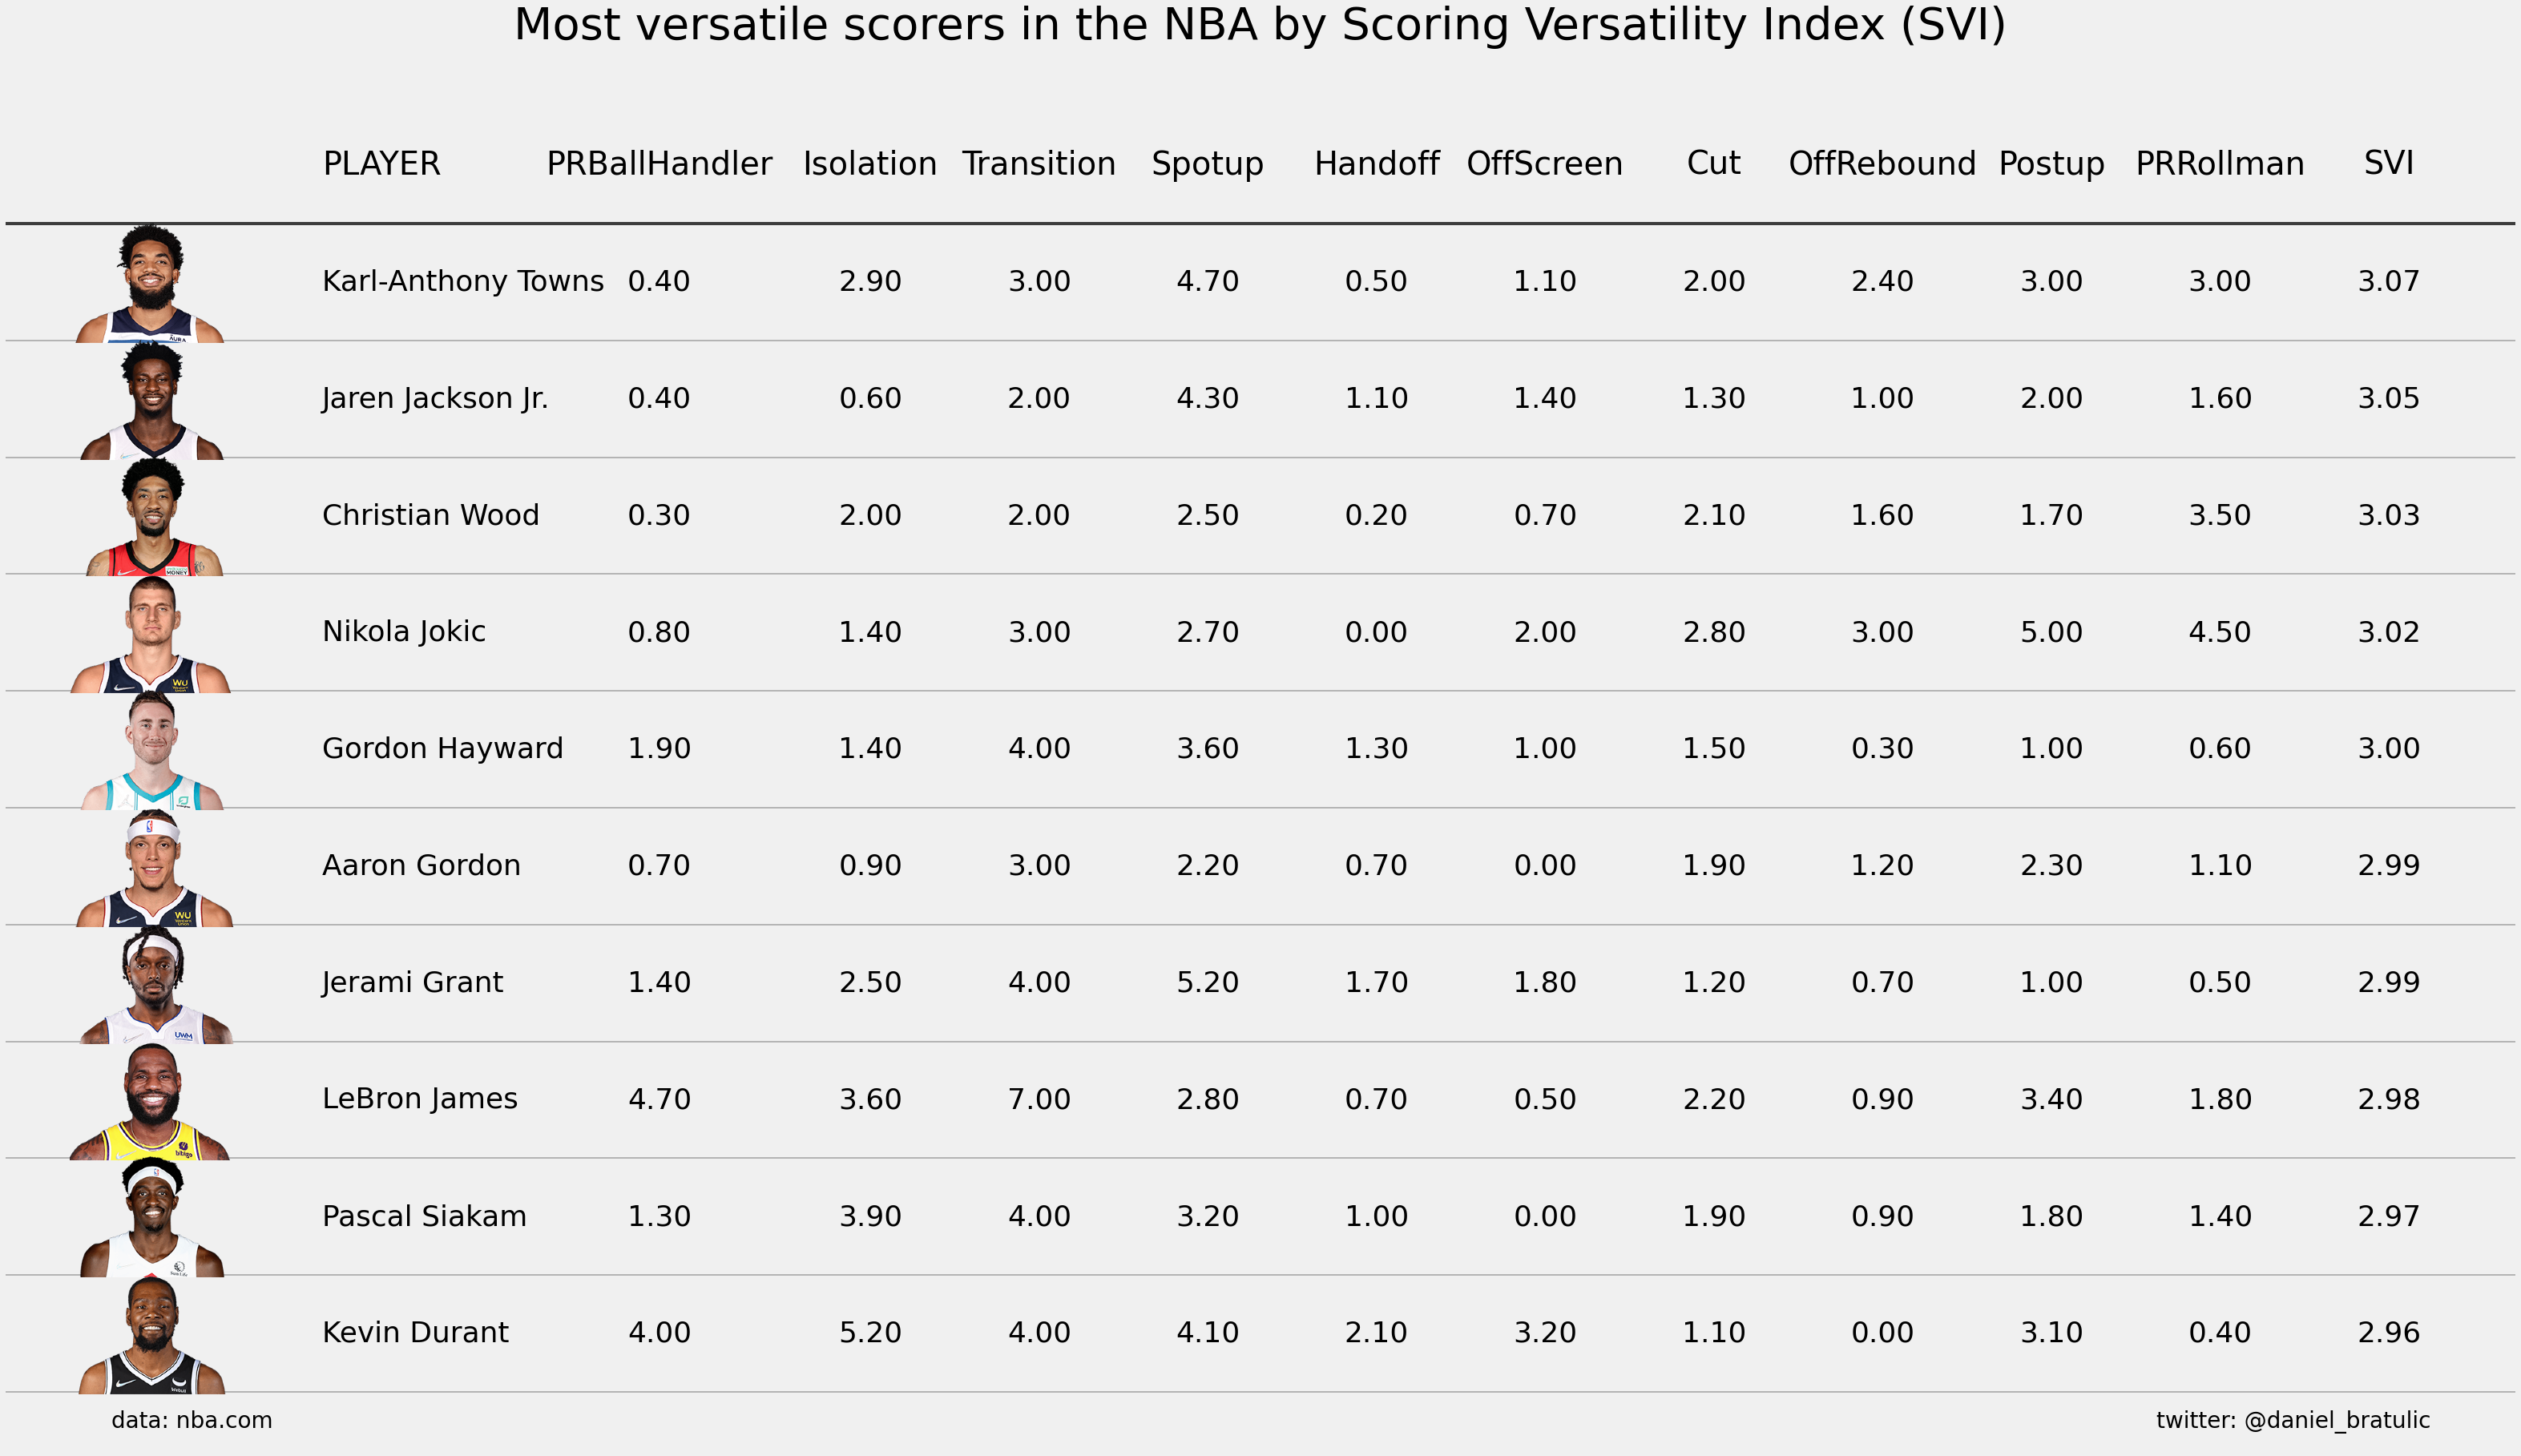

In [72]:
fig, ax = plt.subplots(figsize=(50, 30))
font_size = 36
font_title = 40
top = len(top_20)
#top = 10

for i in range(top):
    item = top_20.iloc[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        #rect = Rectangle((-0.5, y_coord + 0.5), width=5, height=1, fill=True, color=color)
        #ax.add_patch(rect)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.PLAYER_NAME, size=font_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=1.3, y=y_coord, ha='center', va='center', s=f"{item['PTS_PRBallHandler']:.2f}", size=font_size)
    ax.text(x=1.8, y=y_coord, ha='center', va='center', s=f"{item['PTS_Isolation']:.2f}", size=font_size)
    ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item['PTS_Transition']:.2f}", size=font_size)
    ax.text(x=2.6, y=y_coord, ha='center', va='center', s=f"{item['PTS_Spotup']:.2f}", size=font_size)
    ax.text(x=3.0, y=y_coord, ha='center', va='center', s=f"{item['PTS_Handoff']:.2f}", size=font_size)
    ax.text(x=3.4, y=y_coord, ha='center', va='center', s=f"{item['PTS_OffScreen']:.2f}", size=font_size)
    ax.text(x=3.8, y=y_coord, ha='center', va='center', s=f"{item['PTS_Cut']:.2f}", size=font_size)
    ax.text(x=4.2, y=y_coord, ha='center', va='center', s=f"{item['PTS_OffRebound']:.2f}", size=font_size)
    ax.text(x=4.6, y=y_coord, ha='center', va='center', s=f"{item['PTS_Postup']:.2f}", size=font_size)
    ax.text(x=5.0, y=y_coord, ha='center', va='center', s=f"{item['PTS_PRRollman']:.2f}", size=font_size)
    ax.text(x=5.4, y=y_coord, ha='center', va='center', s=f"{item.PLAY_VERSATILITY:.2f}", size=font_size)
    
    ab = AnnotationBbox(get_player_img(find_players_by_full_name(item.PLAYER_NAME)[0]['id']), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    #team_ab = AnnotationBbox(get_team_img(item.TEAM_ID), (2.4, y_coord), frameon=False)
    #ax.add_artist(team_ab)
    #ax.imshow(player_imgs[item.PLAYER_ID], extent=(0, 0.3, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    #ax.imshow(team_igms[item.TEAM_ID], extent=(2.3, 2.5, y_coord-0.35,y_coord + 0.35), aspect='auto', zorder=1)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.5, y=top, s='PLAYER', ha='left', va='center', size=font_title)
#ax.text(x=2.4, y=top, ha='center', va='center', s="TEAM", size=font_title)
#ax.text(x=2.8, y=top, ha='center', va='center', s="GP", size=font_title)
#ax.text(x=3.2, y=top, ha='center', va='center', s="MIN", size=font_title)
ax.text(x=1.3, y=top, ha='center', va='center', s=f"PRBallHandler", size=font_title)
ax.text(x=1.8, y=top, ha='center', va='center', s=f"Isolation", size=font_title)
ax.text(x=2.2, y=top, ha='center', va='center', s=f"Transition", size=font_title)
ax.text(x=2.6, y=top, ha='center', va='center', s=f"Spotup", size=font_title)
ax.text(x=3.0, y=top, ha='center', va='center', s=f"Handoff", size=font_title)
ax.text(x=3.4, y=top, ha='center', va='center', s=f"OffScreen", size=font_title)
ax.text(x=3.8, y=top, ha='center', va='center', s=f"Cut", size=font_title)
ax.text(x=4.2, y=top, ha='center', va='center', s=f"OffRebound", size=font_title)
ax.text(x=4.6, y=top, ha='center', va='center', s=f"Postup", size=font_title)
ax.text(x=5.0, y=top, ha='center', va='center', s=f"PRRollman", size=font_title)
ax.text(x=5.4, y=top, ha='center', va='center', s=f"SVI", size=font_title)

ax.text(x=5.5, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=28)
ax.text(x=0, y=-0.75, s='data: nba.com', ha='left', va='center', size=28)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Most versatile scorers in the NBA by Scoring Versatility Index (SVI)", size=56)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0.25, right=5.7)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('slika.png', dpi=120, bbox_inches='tight')